In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import Row
from datetime import datetime
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SQLContext

In [2]:
app_name = "i_dunno"
player_file = "data/Player.csv"
attributes_file = "data/Player_Attributes.csv"

def toIntSafe(inval):
    try:
        return int(inval)
    except ValueError:
        return None

def toTimeSafe(inval):
    try:
        return datetime.strptime(inval, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        return None

def toFloatSafe(inval):
    try:
        return float(inval)
    except ValueError:
        return 

def stringToPlayer(s):
    return Row(
        toIntSafe(s[0]),
        toIntSafe(s[1]),
        s[2].strip('"'),
        toIntSafe(s[3]),
        toTimeSafe(s[4].strip('"')),
        toFloatSafe(s[5]),
        toIntSafe(s[6]))

def stringToAttributes(s):
    return Row(
        toIntSafe(s[0]),
        toIntSafe(s[1]),
        toIntSafe(s[2]),
        toTimeSafe(s[3].strip('"')),
        toIntSafe(s[4]),
        toIntSafe(s[5]),
        s[6],
        s[7],
        s[8],
        *[toIntSafe(field) for field in s[9:]]
        )

playerSchema = StructType([
    StructField("id", IntegerType(), False),
    StructField("player_api_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("player_fifa_api_id", IntegerType(), True),
    StructField("birthday", TimestampType(), True),
    StructField("height", FloatType(), True),
    StructField("weight", IntegerType(), True)
    ])

finalColumns = ["crossing","finishing","heading_accuracy","short_passing","volleys","dribbling","curve","free_kick_accuracy","long_passing","ball_control","acceleration","sprint_speed","agility","reactions","balance","shot_power","jumping","stamina","strength","long_shots","aggression","interceptions","positioning","vision","penalties","marking","standing_tackle","sliding_tackle","gk_diving","gk_handling","gk_kicking","gk_positioning","gk_reflexes"]

attributesSchema = StructType([
    StructField("id", IntegerType(), False),
    StructField("player_fifa_api_id", IntegerType(), True),
    StructField("player_api_id", IntegerType(), True),
    StructField("date", TimestampType(), True),
    StructField("overall_rating", IntegerType(), True),
    StructField("potential", IntegerType(), True),
    StructField("preferred_foot", StringType(), True),
    StructField("attacking_work_rate", StringType(), True),
    StructField("defensive_work_rate", StringType(), True)] + [StructField(s, IntegerType(), True) for s in finalColumns])



In [3]:
player_rdd = sc.textFile(player_file)
player_header = player_rdd.first()
player_rdd = player_rdd.filter(lambda row: row != player_header).persist()
attributes_rdd = sc.textFile(attributes_file)
attributes_header = attributes_rdd.first()
attributes_rdd = attributes_rdd.filter(lambda row: row != attributes_header).persist()
player_rdd.count()
attributes_rdd.count()

183978

In [4]:
player_df = sqlContext.createDataFrame(player_rdd.map(lambda row: stringToPlayer(row.split(','))), playerSchema)
attributes_df = sqlContext.createDataFrame(attributes_rdd.map(lambda row: stringToAttributes(row.split(','))), attributesSchema)

In [5]:
player_merge=player_df.join(attributes_df,player_df.player_api_id==attributes_df.player_api_id,'left').select(player_df.id, player_df.player_api_id, player_df.player_fifa_api_id,"player_name", "birthday", "height", "weight", "date", "overall_rating", "potential", "preferred_foot", "attacking_work_rate","defensive_work_rate","crossing","finishing","heading_accuracy","short_passing","volleys","dribbling","curve","free_kick_accuracy","long_passing","ball_control","acceleration","sprint_speed","agility","reactions","balance","shot_power","jumping","stamina","strength","long_shots","aggression","interceptions","positioning","vision","penalties","marking","standing_tackle","sliding_tackle","gk_diving","gk_handling","gk_kicking","gk_positioning","gk_reflexes")

In [6]:
#cached parent DF for final DF below to save in memory and aid computation time
player_merge.cache()
player_merge.first()

Row(id=3402, player_api_id=11317, player_fifa_api_id=153267, player_name=u'Florent Ghisolfi', birthday=datetime.datetime(1985, 2, 28, 0, 0), height=175.25999450683594, weight=154, date=datetime.datetime(2014, 3, 21, 0, 0), overall_rating=64, potential=65, preferred_foot=u'right', attacking_work_rate=u'medium', defensive_work_rate=u'medium', crossing=44, finishing=40, heading_accuracy=59, short_passing=67, volleys=40, dribbling=61, curve=41, free_kick_accuracy=49, long_passing=65, ball_control=63, acceleration=58, sprint_speed=61, agility=60, reactions=69, balance=74, shot_power=53, jumping=62, stamina=71, strength=64, long_shots=57, aggression=76, interceptions=61, positioning=55, vision=63, penalties=44, marking=55, standing_tackle=71, sliding_tackle=61, gk_diving=7, gk_handling=10, gk_kicking=15, gk_positioning=5, gk_reflexes=9)

# FeaturesExtraction

In [7]:
#Calculation of Age
df2=player_merge.withColumn('age',datediff('date','birthday')/365.0)
df2=df2.withColumn("intage",df2["age"].cast(IntegerType())).drop('age').withColumnRenamed("intage","age")

In [8]:
df2.registerTempTable('players')

In [9]:
## Select unique player rows as most recent complete attribute data per player
uniq_playersDF = sqlContext.sql("""
Select *
    from players
    inner join 
    (
        Select max(date) as LatestDate, player_api_id as id2
        from players
        WHERE crossing is not null 
            and finishing is not null
            and heading_accuracy is not null
            and short_passing is not null
            and volleys is not null
            and dribbling is not null
            and curve is not null
            and free_kick_accuracy is not null
            and long_passing is not null
            and ball_control is not null
            and acceleration is not null
            and sprint_speed is not null
            and agility is not null
            and reactions is not null
            and balance is not null
            and shot_power is not null
            and jumping is not null
            and stamina is not null
            and strength is not null
            and long_shots is not null
            and aggression is not null
            and interceptions is not null
            and positioning is not null
            and vision is not null
            and penalties is not null
            and marking is not null
            and standing_tackle is not null
            and sliding_tackle is not null
            and gk_diving is not null
            and gk_handling is not null
            and gk_kicking is not null
            and gk_positioning is not null
            and gk_reflexes is not null
        Group by player_api_id
    ) as rhs
    on date = LatestDate
    and player_api_id = id2
    WHERE overall_rating is not null
    """)
uniq_playersDF.registerTempTable('players2')

In [29]:
# Define attribute score columns, and categories of attributes
attributes = ['crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
             'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control',
             'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance',
             'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
             'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
             'marking', 'standing_tackle', 'sliding_tackle',
             'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']

attr_cats = ['movement', 'attacking', 'skill', 'power', 'mentality',
             'defending', 'goalkeeping']

attacking = attributes[:5]
skill = attributes[5:10]
movement = attributes[10:15]
power = attributes[15:20]
mentality = attributes[20:25]
defending = attributes[25:28]
goalkeeping = attributes[28:]

In [32]:
# Calculate total attribute and category averages, and standardize category scores by dividing by overall average
query = """
SELECT *, 
    movement_avg_score/tot_avg_score as movement_std_score, 
    attacking_avg_score/tot_avg_score as attacking_std_score, 
    skill_avg_score/tot_avg_score as skill_std_score, 
    power_avg_score/tot_avg_score as power_std_score, 
    mentality_avg_score/tot_avg_score as mentality_std_score, 
    defending_avg_score/tot_avg_score as defending_std_score, 
    goalkeeping_avg_score/tot_avg_score as goalkeeping_std_score 
        
FROM (
    SELECT *, ({})/{} as tot_avg_score
    FROM (SELECT  *, (({})/{}) as movement_avg_score, 
                     (({})/{}) as attacking_avg_score, 
                     (({})/{}) as skill_avg_score, 
                     (({})/{}) as power_avg_score, 
                     (({})/{}) as mentality_avg_score, 
                     (({})/{}) as defending_avg_score, 
                     (({})/{}) as goalkeeping_avg_score
          FROM players2) as category_scores
     ) as total_averages
""".format("_avg_score+".join(attr_cats) + "_avg_score", len(attr_cats),
                      "+".join(movement), len(movement),
                      "+".join(attacking), len(attacking),
                      "+".join(skill), len(skill),
                      "+".join(power), len(power),
                      "+".join(mentality), len(mentality),
                      "+".join(defending), len(defending),
                      "+".join(goalkeeping), len(goalkeeping)
                      )
std_scoreDF = sqlContext.sql(query)

In [35]:
std_scoreDF.select(std_scoreDF.columns[-7:]).show()

+------------------+-------------------+------------------+------------------+-------------------+-------------------+---------------------+
|movement_std_score|attacking_std_score|   skill_std_score|   power_std_score|mentality_std_score|defending_std_score|goalkeeping_std_score|
+------------------+-------------------+------------------+------------------+-------------------+-------------------+---------------------+
|1.2421013960323295| 0.9643644379132992|1.0762307127112418|1.1842395297575314| 1.1533798677443057| 1.2022409992652463|  0.17744305657604703|
|1.4752781211372064| 1.2546353522867737|1.1161928306551296|1.2373300370828182| 1.1681087762669962| 0.5407911001236093|  0.20766378244746597|
|1.0984743411927878| 0.7905686546463245|0.8072122052704576| 1.360610263522885| 1.0984743411927878| 1.6574202496532593|  0.18723994452149792|
|1.2015007034547442|  1.214631858683758|1.1653900265749568| 1.132562138502423| 1.1292793496951694| 0.9793653274972642|   0.1772705955916836|
|1.0834782608

# Clustering

In [12]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans as KMeansMl
from pyspark.mllib.clustering import KMeans as KMeansMllib
from pyspark.mllib.linalg import Vectors
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/PhilRotella/anaconda3/envs/msan/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [36]:
transformer = VectorAssembler(outputCol = 'features', 
                              inputCols = std_scoreDF.columns[-7:])

In [37]:
points = transformer.transform(std_scoreDF).select('features')

In [38]:
kMeans_rdd = points.rdd.map(lambda data: Vectors.dense([c for c in data])).cache()

In [39]:
kMeans_rdd.take(1)

[DenseVector([1.2421, 0.9644, 1.0762, 1.1842, 1.1534, 1.2022, 0.1774])]

In [40]:
wssse_list = [0 for x in range(0, 20)]
for k in range(3, 20):
    model = KMeansMllib.train(kMeans_rdd, k)
    avg_wssse = model.computeCost(kMeans_rdd) / k
    wssse_list[k] = avg_wssse

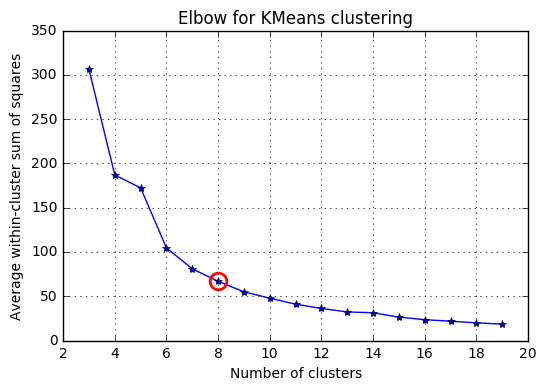

In [41]:
K = range(3, 20)
avg_wssse = wssse_list[3:]
elbow_ix = 5 #elbow point for curve, k = 8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avg_wssse, 'b*-')
ax.plot(K[elbow_ix], avg_wssse[elbow_ix], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

In [42]:
[wssse_list[x] - wssse_list[x + 1] for x in range(3, 19)]

[119.1665789842572,
 14.598741149209644,
 67.76562131693582,
 23.59561240931089,
 14.152294006777495,
 11.888639426586892,
 7.1377156363887835,
 6.7681608088383385,
 4.844687474018166,
 3.8773768850848,
 0.9676538094509475,
 4.931556157267952,
 2.887823839758653,
 1.6758899374101475,
 1.9122443646896414,
 1.4182894911077284]

In [43]:
# Final clustering with k = 8
k = 8
model = KMeansMllib.train(kMeans_rdd, 8)
centers = model.clusterCenters

In [44]:
## Assign clusters to playerIds
from pyspark.sql.functions import monotonically_increasing_id
player_clusters = model.predict(kMeans_rdd) #clusters RDD
# create clusters DF with row ids
player_clustersDF = player_clusters.toDF(IntegerType()).withColumnRenamed('value', 'cluster').withColumn('cluster_row_id', monotonically_increasing_id())
# add row ids to main DF
resultsDF = std_scoreDF.withColumn('row_id', monotonically_increasing_id())
# join main df with clusters on row ids
resultsDF = resultsDF.join(player_clustersDF, resultsDF.row_id == player_clustersDF.cluster_row_id, 'inner')

In [49]:
resultsDF.write.saveAsTable('final_results')

# Radar Plots

In [45]:
from radar_chart import *

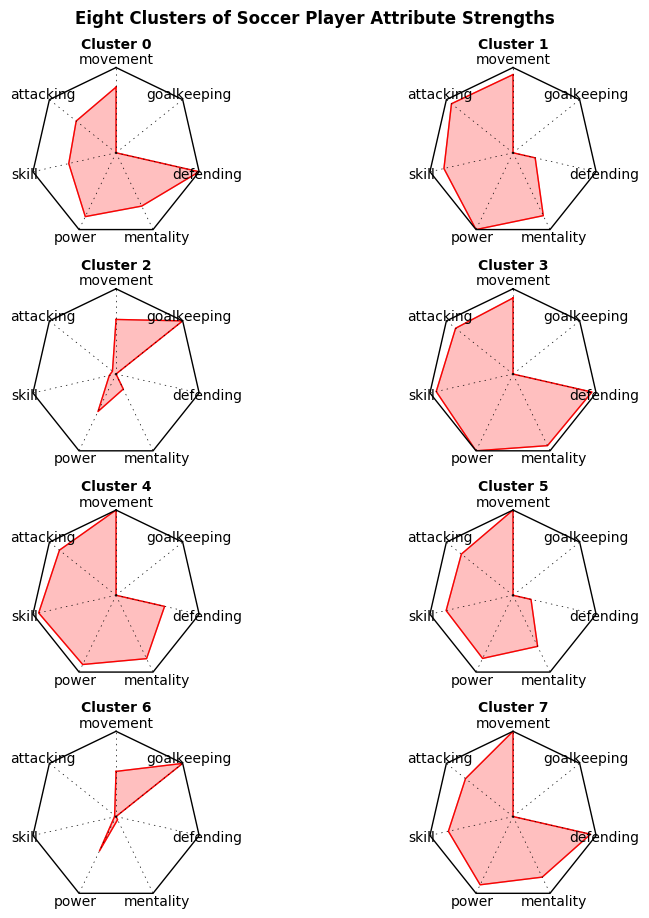

In [59]:
N = 7
theta = radar_factory(N, frame='polygon')

data = [("Cluster {}".format(x), list(centers[x])) for x in range(k)]
spoke_labels = attr_cats

fig, axes = plt.subplots(figsize=(9, 9), nrows=4, ncols=2,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
# Plot the 8 clusters on separate axes
for ax, (title, case_data) in zip(axes.flatten(), data):
    ax.set_rgrids([0.1, 2.1])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    ax.plot(theta, case_data, color='r')
    ax.fill(theta, case_data, facecolor='r', alpha=0.25)
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
ax = axes[0, 0]
#labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = ax.legend(labels, loc=(0.9, .95),
#                   labelspacing=0.1, fontsize='small')

fig.text(0.5, 1, 'Eight Clusters of Soccer Player Attribute Strengths',
         horizontalalignment='center', color='black', weight='bold',
         size='large')
fig.tight_layout()
plt.show()
plt.close()

In [76]:
query = """
SELECT cluster, round(avg(overall_rating), 2) as overall, 
    min(overall_rating) as min_overall, 
    max(overall_rating) as max_overall, 
    round(avg(potential),2) as potential, 
    round(avg(age),2) as age, 
    round(avg(height),2) as height, 
    round(avg(weight),2) as weight,
    round(avg(weight) * .45 / (avg(height)/100 * avg(height)/100), 2) as bmi
FROM final_results
GROUP BY 1
ORDER BY 2 DESC
"""
sqlContext.sql(query).show()

+-------+-------+-----------+-----------+---------+-----+------+------+-----+
|cluster|overall|min_overall|max_overall|potential|  age|height|weight|  bmi|
+-------+-------+-----------+-----------+---------+-----+------+------+-----+
|      3|  69.49|         49|         87|    71.07|29.46| 182.5|169.88|22.95|
|      1|  69.22|         53|         93|    71.27|28.45|184.65|175.59|23.18|
|      2|  69.04|         51|         90|    71.24|29.23|188.78| 184.5| 23.3|
|      0|  68.73|         49|         88|    71.27|27.86|186.55| 177.7|22.98|
|      5|  68.16|         47|         94|    72.46|25.12|177.07|157.82|22.65|
|      4|  67.96|         48|         88|    71.21|26.87|178.16|160.11| 22.7|
|      7|  65.87|         47|         87|    69.84|25.79|179.23|162.09|22.71|
|      6|  63.78|         48|         81|    65.91|30.28|188.68|183.73|23.22|
+-------+-------+-----------+-----------+---------+-----+------+------+-----+



In [67]:
query = """
SELECT player_name, overall_rating, cluster
FROM final_results
WHERE overall_rating > 86
ORDER BY 2 DESC
"""
sqlContext.sql(query).show(100)

+------------------+--------------+-------+
|       player_name|overall_rating|cluster|
+------------------+--------------+-------+
|      Lionel Messi|            94|      5|
| Cristiano Ronaldo|            93|      1|
|       Luis Suarez|            90|      1|
|            Neymar|            90|      5|
|      Manuel Neuer|            90|      2|
|      Arjen Robben|            89|      5|
|Zlatan Ibrahimovic|            89|      1|
|       Mesut Oezil|            88|      5|
|    Andres Iniesta|            88|      4|
|       Eden Hazard|            88|      5|
|      Thiago Silva|            88|      0|
|Robert Lewandowski|            88|      1|
|     Sergio Aguero|            88|      5|
|       Gareth Bale|            87|      4|
|      Sergio Ramos|            87|      3|
|   James Rodriguez|            87|      1|
|        Toni Kroos|            87|      3|
|    Jerome Boateng|            87|      0|
|      David De Gea|            87|      2|
|      Philipp Lahm|            

In [69]:
resultsDF.columns

['id',
 'player_api_id',
 'player_fifa_api_id',
 'player_name',
 'birthday',
 'height',
 'weight',
 'date',
 'overall_rating',
 'potential',
 'preferred_foot',
 'attacking_work_rate',
 'defensive_work_rate',
 'crossing',
 'finishing',
 'heading_accuracy',
 'short_passing',
 'volleys',
 'dribbling',
 'curve',
 'free_kick_accuracy',
 'long_passing',
 'ball_control',
 'acceleration',
 'sprint_speed',
 'agility',
 'reactions',
 'balance',
 'shot_power',
 'jumping',
 'stamina',
 'strength',
 'long_shots',
 'aggression',
 'interceptions',
 'positioning',
 'vision',
 'penalties',
 'marking',
 'standing_tackle',
 'sliding_tackle',
 'gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_positioning',
 'gk_reflexes',
 'age',
 'LatestDate',
 'id2',
 'movement_avg_score',
 'attacking_avg_score',
 'skill_avg_score',
 'power_avg_score',
 'mentality_avg_score',
 'defending_avg_score',
 'goalkeeping_avg_score',
 'tot_avg_score',
 'movement_std_score',
 'attacking_std_score',
 'skill_std_score',
 'power_std_